In [18]:
# Using the model for prediction

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

In [280]:
#!pip install yfinance
import yfinance as yf
from datetime import datetime, timedelta

In [281]:
def Get_Last_Stock_Values(Tickers):

    # Get current date and time
    current_time = datetime.now()

    # Get closing time of the stock market (Assuming 16:00 as closing time)
    closing_time = current_time.replace(hour=16, minute=0, second=0, microsecond=0)

    # Check if current time is after closing time
    if current_time > closing_time:
        # If after closing time, set start_date as today
        end_date = current_time.strftime("%Y-%m-%d")
    else:
        # If before closing time, set start_date as yesterday
        end_date = (current_time - timedelta(days=1)).strftime("%Y-%m-%d")

    # Set end_date as N days ago from the start_date
    start_date = (datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=60)).strftime("%Y-%m-%d")

    for Ticker in Tickers:
        stock_data = yf.download(Ticker, start=start_date, end=end_date)
        if len(stock_data)>0: 
            stock_data.to_csv(f'Data/Stock_Values/{Ticker}.csv')
        else:
            print('Warning: No data returned from API')

In [327]:
def import_data(look_back, Ticker, step_lenght):
    
    Data_url= f'Data/Stock_Values/{Ticker}.csv'
    dataset= pd.DataFrame(pd.read_csv(Data_url)['Close']).values.astype('float32')
    dates_df= pd.read_csv(Data_url)['Date']
    # normalize the dataset with MinMax normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    dataset= dataset[::-step_lenght][::-1]
    dates_df= dates_df[::-step_lenght][::-1]
    
    testX= dataset[-look_back:, 0].reshape(1, 1, -1)
    dates= dates_df[-look_back:]
    
    return testX, scaler, dates.values

In [321]:
def run_model(testX, scaler, Model_url, look_back, No_steps):
    # Load the saved model
    model = load_model(Model_url)
    
    Data= testX
    for step in range(1, No_steps+1):
        # make predictions
        testPredict = model.predict(Data[0][0][-look_back:].reshape(1,1,-1))
        
        # Concatenate along the last axis       
        Data = np.concatenate((Data, np.reshape(testPredict, (1, 1, 1))), axis=-1)
    
    Data = scaler.inverse_transform(Data[0]).reshape(1,1,-1)
    return Data

In [322]:
def plot_graph(testPredict, look_back, No_steps, Dates):
    
    Xtest= testPredict[0][0][0:look_back]
    Xpred= testPredict[0][0][look_back-1:]

    # plot baseline and predictions   
    plt.plot(Dates[:look_back], Xtest, 'bo-')
    plt.plot(Dates[look_back-1: look_back+No_steps+1], Xpred, 'ro--')
    plt.xticks(rotation='vertical') 
    
    plt.show()

In [331]:
def date_set(dates, No_steps, step_lenght):
    next_dates = []
    last_date= datetime.strptime(dates[-1], "%Y-%m-%d")
    for _ in range(No_steps):
        next_date = (last_date + timedelta(days= step_lenght)).strftime("%Y-%m-%d")
        last_date= datetime.strptime(next_date, "%Y-%m-%d")
        next_dates.append(next_date)
    Dates= np.concatenate((dates, next_dates), axis=-1)
    return Dates

In [324]:
Data_url= f'Data/Stock_Values/AZEK.csv' 
Model_url= 'Saved_Models/stock_prediction_model.h5' 
Tickers = ['AZEK']  # Example Ticker symbol 
look_back= 8
No_steps= 5
step_lenght= 5


testX, scaler, dates, dataset = import_data(look_back, Tickers[0], step_lenght)

In [332]:
def main():
    Data_url= f'Data/Stock_Values/AZEK.csv' 
    Model_url= 'Saved_Models/stock_prediction_model.h5' 
    Tickers = ['AZEK']  # Example Ticker symbol 
    look_back= 8
    No_steps= 5
    step_lenght= 5
    
    #Get_Last_Stock_Values(Tickers)
    
    testX, scaler, dates = import_data(look_back, Tickers[0], step_lenght)
    
    testPredict= run_model(testX, scaler, Model_url, look_back, No_steps)
    
    Dates= date_set(dates, No_steps, step_lenght)
    
    plot_graph(testPredict, look_back, No_steps, Dates)
    

1/1 [==============================] - 0s 19ms/step


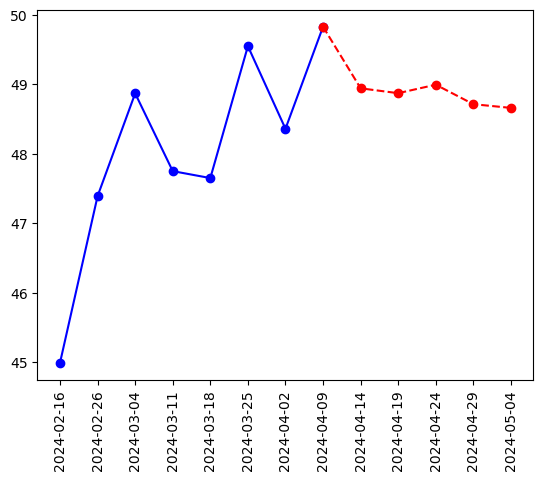

In [333]:
if __name__ == "__main__":
    main()